In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

In [2]:
# simulation parameters
# number of simulated samples
n = 200

# number of simulated features
p = 500

# number of features that are informative, i.e. correlated with the label
n_informative = 20

# number of features that are redundant (linear combinations of informative features)
n_redundant = 20

# number of clusters per class (higher = more difficult classification problem)
n_clusters_per_class = 2

# class imbalance ([0.5, 0.5] = balanced, more imbalanced = more difficult)
class_weights = [0.6, 0.4]

# whether to standardize features before fitting classifiers
standardize = True

# whether to take PCA of features (i.e. de-correlate classifier input) before fitting classifiers
preprocess_pca = False

In [3]:
def generate_dataset(preprocess_pca=False,
                     pca_n_components=50,
                     random_state=42):
    X, y = make_classification(n_samples=n,
                               n_features=p,
                               n_informative=n_informative,
                               n_redundant=n_redundant,
                               n_clusters_per_class=n_clusters_per_class,
                               weights=class_weights,
                               class_sep=1.75,
                               flip_y=0.0,
                               random_state=random_state)
    if standardize:
        X = StandardScaler().fit_transform(X)
    if preprocess_pca:
        X = PCA(n_components=pca_n_components).fit_transform(X)
    return X, y

X, y = generate_dataset(preprocess_pca)

print(X.shape)
print(X[:5, :5])

(200, 500)
[[-0.6732641   1.44143815  0.65603173 -1.25555873 -0.10252406]
 [-0.30245457  1.54424263  0.12990593  0.07116968 -0.04269515]
 [-0.15725554  1.12867016  0.3026934   0.67613557 -0.60526114]
 [-0.99042465  1.21576172 -0.92570551  0.01008096  0.93380763]
 [-0.01717207 -0.00281123 -0.6395784  -0.95346678  1.77233893]]


In [4]:
print(y.shape)
print(y[:5])

(200,)
[0 0 0 1 0]


In [5]:
def get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test):
    """Given predicted scores and true labels for train and test samples,
    calculate classification metrics.

    y_pred_train and y_pred_test should be continuous (higher = more likely
    to be positively labeled, e.g. output of logistic regression); true values
    are binary.
    """
    train_auroc = roc_auc_score(y_train, y_pred_train, average="weighted")
    test_auroc = roc_auc_score(y_test, y_pred_test, average="weighted")

    train_aupr = average_precision_score(y_train, y_pred_train, average="weighted")
    test_aupr = average_precision_score(y_test, y_pred_test, average="weighted")

    return {
        'train_auroc': train_auroc,
        'test_auroc': test_auroc,
        'train_aupr': train_aupr,
        'test_aupr': test_aupr,
    }

In [6]:
def get_loss(y_train,
             y_pred_train,
             penalty=None,
             weights=None,
             param=None):
    log_likelihood = log_loss(y_train, y_pred_train)
    penalty_fn = 0.0
    if penalty == 'l1':
        penalty_fn = param * np.sum(np.absolute(weights))
    elif penalty == 'l2':
        penalty_fn = (0.5 * param * np.sum(weights ** 2))
    return log_likelihood, penalty_fn

def get_eta0(lr_schedule):
    eta0 = 0.0
    if lr_schedule in ['invscaling', 'adaptive']:
        eta0 = 0.1
    elif lr_schedule == 'constant':
        eta0 = 0.005
    return eta0

def get_eta0_constant_search(
    X_train,
    y_train,
    penalty=None,
    sgd_param=None,
    eta0_range=[0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.01]
):
    clf_parameters = {'eta0': eta0_range}
    if penalty is None:
        sgd = SGDClassifier(
            loss='log_loss',
            random_state=seed,
            learning_rate='constant'
        )
    else:
        sgd = SGDClassifier(
            loss='log_loss',
            random_state=seed,
            penalty=penalty,
            alpha=sgd_param,
            learning_rate='constant'
        )
    cv_pipeline = GridSearchCV(
        estimator=sgd,
        param_grid=clf_parameters,
        cv=3,
        scoring='average_precision',
        return_train_score=True
    )
    cv_pipeline.fit(X=X_train, y=y_train)
    return cv_pipeline.best_params_['eta0']
    

In [8]:
results = []
results_cols = None
seeds = [42, 1]
coefs = {
    'constant': [],
    'constant_search': [],
    'optimal': [],
    'invscaling': [],
    'adaptive': []
}
# no regularization for now
for seed in seeds:
    
    X, y = generate_dataset(preprocess_pca=preprocess_pca, random_state=seed)
    
    kf = KFold(n_splits=4)
    for fold, (train_ix, test_ix) in enumerate(kf.split(X)):
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        for lr_schedule in coefs.keys():
            
            if lr_schedule == 'constant_search':
                eta0 = get_eta0_constant_search(X_train, y_train)
            else:
                eta0 = get_eta0(lr_schedule)
            
            sgd = SGDClassifier(
                loss='log_loss',
                random_state=seed,
                learning_rate=lr_schedule.split('_')[0],
                eta0=eta0
            ).fit(X_train, y_train)

            y_pred_train = sgd.predict(X_train)
            y_pred_test = sgd.predict(X_test)

            prob_metrics = get_prob_metrics(y_train, y_test,
                                            y_pred_train, y_pred_test)

            if results_cols is None:
                results_cols = list(prob_metrics.keys()) + ['lr_schedule', 'seed', 'fold']
            else:
                assert results_cols == (list(prob_metrics.keys()) + ['lr_schedule', 'seed', 'fold'])
            results.append(list(prob_metrics.values()) + [lr_schedule, seed, fold])

            coefs[lr_schedule].append([seed, fold, sgd.coef_])

    results_df = (
        pd.DataFrame(results, columns=results_cols)
          .melt(id_vars=['lr_schedule', 'seed', 'fold'], var_name='metric')
    )

print(results_df.shape)
results_df.head()

42 5e-06
42 5e-06
42 5e-06
42 5e-06
1 5e-06
1 0.001
1 5e-05
1 0.001
(160, 5)


,lr_schedule,seed,fold,metric,value
0,constant,42,0,train_auroc,1.000000
1,constant_search,42,0,train_auroc,0.955556
2,optimal,42,0,train_auroc,1.000000
3,invscaling,42,0,train_auroc,1.000000
4,adaptive,42,0,train_auroc,1.000000


In [9]:
# get coefficient vector magnitudes
baseline_coefs_df = []

for lr_schedule in coefs.keys():
    for [seed, fold, coef] in coefs[lr_schedule]:
        baseline_coefs_df.append([lr_schedule, seed, fold, np.sum(np.absolute(coef))])
    
baseline_coefs_df = pd.DataFrame(
    baseline_coefs_df, columns=['lr_schedule', 'seed', 'fold', 'sum_coefs']
)

print(baseline_coefs_df.shape)
baseline_coefs_df.head()

(40, 4)


,lr_schedule,seed,fold,sum_coefs
0,constant,42,0,37.328301
1,constant,42,1,35.296354
2,constant,42,2,37.066850
3,constant,42,3,36.363676
4,constant,1,0,30.561731


<AxesSubplot:xlabel='metric', ylabel='value'>

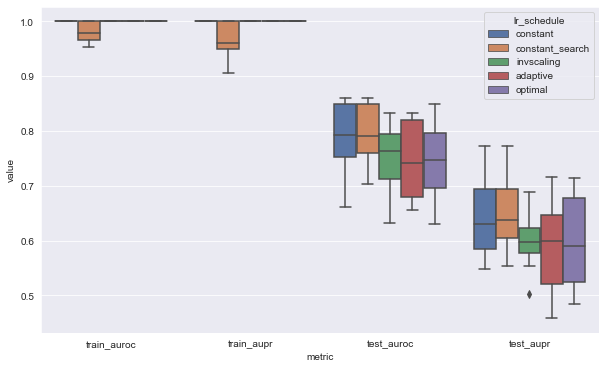

In [10]:
sns.set({'figure.figsize': (10, 6)})

sns.boxplot(data=results_df.sort_values(by='metric', ascending=False),
            x='metric', y='value', hue='lr_schedule')

In [13]:
results = []
results_cols = None

coefs = {
    'constant': [],
    'constant_search': [],
    'optimal': [],
    'invscaling': [],
    'adaptive': []
}

losses = []

seeds = [42, 1]
sgd_params = np.logspace(-8, 1, 19)

for seed in seeds:
    
    X, y = generate_dataset(preprocess_pca=preprocess_pca, random_state=seed)
    
    kf = KFold(n_splits=4)

    # L1 regularization
    for fold, (train_ix, test_ix) in enumerate(kf.split(X)):
        print('seed:', seed, 'fold:', fold)
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        for lr_schedule in coefs.keys():
            
            for sgd_param in sgd_params:
                
                if lr_schedule == 'constant_search':
                    eta0 = get_eta0_constant_search(
                        X_train, y_train, penalty='l1', sgd_param=sgd_param
                    )
                else:
                    eta0 = get_eta0(lr_schedule)
                    
                sgd = (
                    SGDClassifier(loss='log_loss',
                                  penalty='l1',
                                  alpha=sgd_param,
                                  random_state=seed,
                                  learning_rate=lr_schedule.split('_')[0],
                                  eta0=eta0,
                                  max_iter=500)
                ).fit(X_train, y_train)
                y_pred_train = sgd.predict(X_train)
                y_pred_test = sgd.predict(X_test)
                prob_metrics = get_prob_metrics(y_train, y_test,
                                                y_pred_train, y_pred_test)
                if results_cols is None:
                    results_cols = (list(prob_metrics.keys()) +
                                    ['lr_schedule', 'seed', 'fold', 'lasso_param'])
                else:
                    assert results_cols == (list(prob_metrics.keys()) +
                                            ['lr_schedule', 'seed', 'fold', 'lasso_param'])
                results.append(list(prob_metrics.values()) +
                               [lr_schedule, seed, fold, sgd_param])
                coefs[lr_schedule].append([seed, fold, sgd_param, sgd.coef_])

                sgd_logl, sgd_penalty = get_loss(
                    y_train, y_pred_train,
                    penalty='l1', weights=sgd.coef_, param=sgd_param
                )
                losses.append([lr_schedule, seed, fold, sgd_param, sgd_logl, sgd_penalty])

results_df = (
    pd.DataFrame(results, columns=results_cols)
      .melt(id_vars=['lr_schedule', 'seed', 'fold', 'lasso_param'], var_name='metric')
)

print(results_df.shape)
results_df.head()

42 0 1e-08 5e-06
42 0 3.162277660168379e-08 5e-06
42 0 1e-07 5e-06
42 0 3.162277660168379e-07 5e-06
42 0 1e-06 5e-06
42 0 3.162277660168379e-06 5e-06
42 0 1e-05 5e-06
42 0 3.1622776601683795e-05 5e-06
42 0 0.0001 5e-06
42 0 0.00031622776601683794 5e-06
42 0 0.001 5e-06
42 0 0.0031622776601683794 5e-06
42 0 0.01 1e-05
42 0 0.03162277660168379 5e-05
42 0 0.1 0.0005
42 0 0.31622776601683794 5e-06
42 0 1.0 5e-06
42 0 3.1622776601683795 5e-06
42 0 10.0 5e-06
42 1 1e-08 5e-06
42 1 3.162277660168379e-08 5e-06
42 1 1e-07 5e-06
42 1 3.162277660168379e-07 5e-06
42 1 1e-06 5e-06
42 1 3.162277660168379e-06 5e-06
42 1 1e-05 5e-06
42 1 3.1622776601683795e-05 5e-06
42 1 0.0001 5e-06
42 1 0.00031622776601683794 5e-06
42 1 0.001 5e-06
42 1 0.0031622776601683794 0.01
42 1 0.01 0.01
42 1 0.03162277660168379 0.01
42 1 0.1 0.001
42 1 0.31622776601683794 5e-06
42 1 1.0 5e-06
42 1 3.1622776601683795 5e-06
42 1 10.0 5e-06
42 2 1e-08 5e-06
42 2 3.162277660168379e-08 5e-06
42 2 1e-07 5e-06
42 2 3.16227766016837

,lr_schedule,seed,fold,lasso_param,metric,value
0,constant,42,0,1.000000e-08,train_auroc,1.0
1,constant,42,0,3.162278e-08,train_auroc,1.0
2,constant,42,0,1.000000e-07,train_auroc,1.0
3,constant,42,0,3.162278e-07,train_auroc,1.0
4,constant,42,0,1.000000e-06,train_auroc,1.0


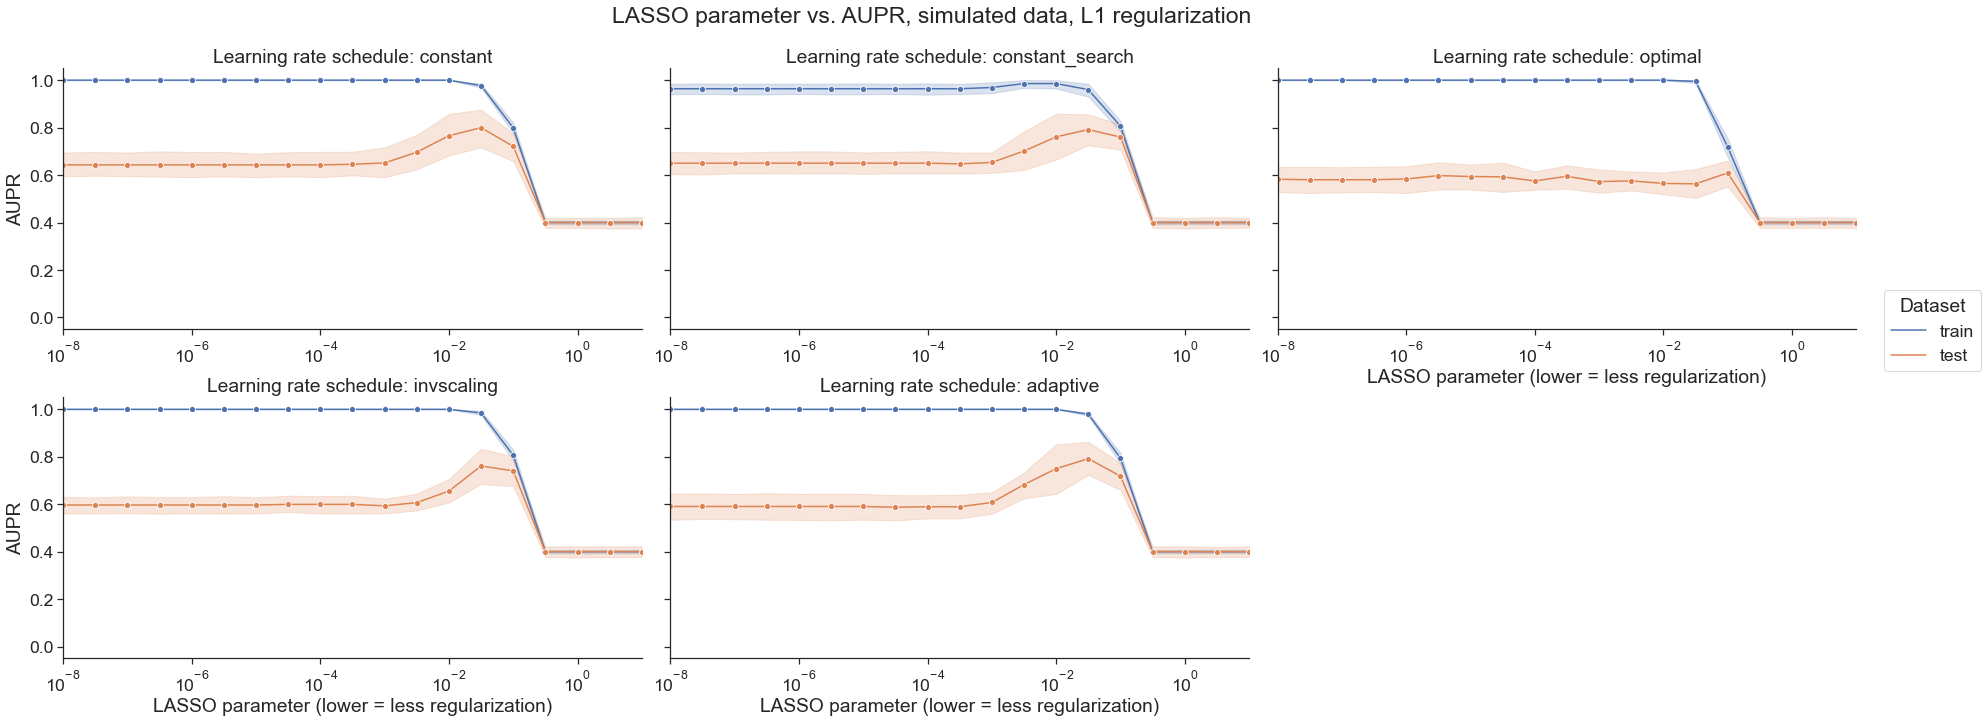

In [14]:
sns.set_style('ticks')

plot_df = results_df[results_df.metric.isin(['train_aupr', 'test_aupr'])]

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y='value', hue='metric',
        hue_order=['train_aupr', 'test_aupr'],
        marker='o', kind='line', col='lr_schedule',
        col_wrap=3, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log', xlim=(10e-9, 10), ylim=(-0.05, 1.05))
    g.set_xlabels('LASSO parameter (lower = less regularization)')
    g.set_ylabels('AUPR')
    sns.move_legend(g, 'center', bbox_to_anchor=[1.035, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Learning rate schedule: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. AUPR, simulated data, L1 regularization', y=1.0)

plt.tight_layout()

In [15]:
# get coefficient vector magnitudes
coefs_df = []

for lr_schedule in coefs.keys():
    for [seed, fold, param, coef] in coefs[lr_schedule]:
        coefs_df.append([lr_schedule, seed, fold, param, np.sum(np.absolute(coef))])
    
coefs_df = pd.DataFrame(
    coefs_df, columns=['lr_schedule', 'seed', 'fold', 'lasso_param', 'sum_coefs']
)

print(coefs_df.shape)
coefs_df.head()

(760, 5)


,lr_schedule,seed,fold,lasso_param,sum_coefs
0,constant,42,0,1.000000e-08,37.360336
1,constant,42,0,3.162278e-08,37.360200
2,constant,42,0,1.000000e-07,37.359771
3,constant,42,0,3.162278e-07,37.358416
4,constant,42,0,1.000000e-06,37.354129


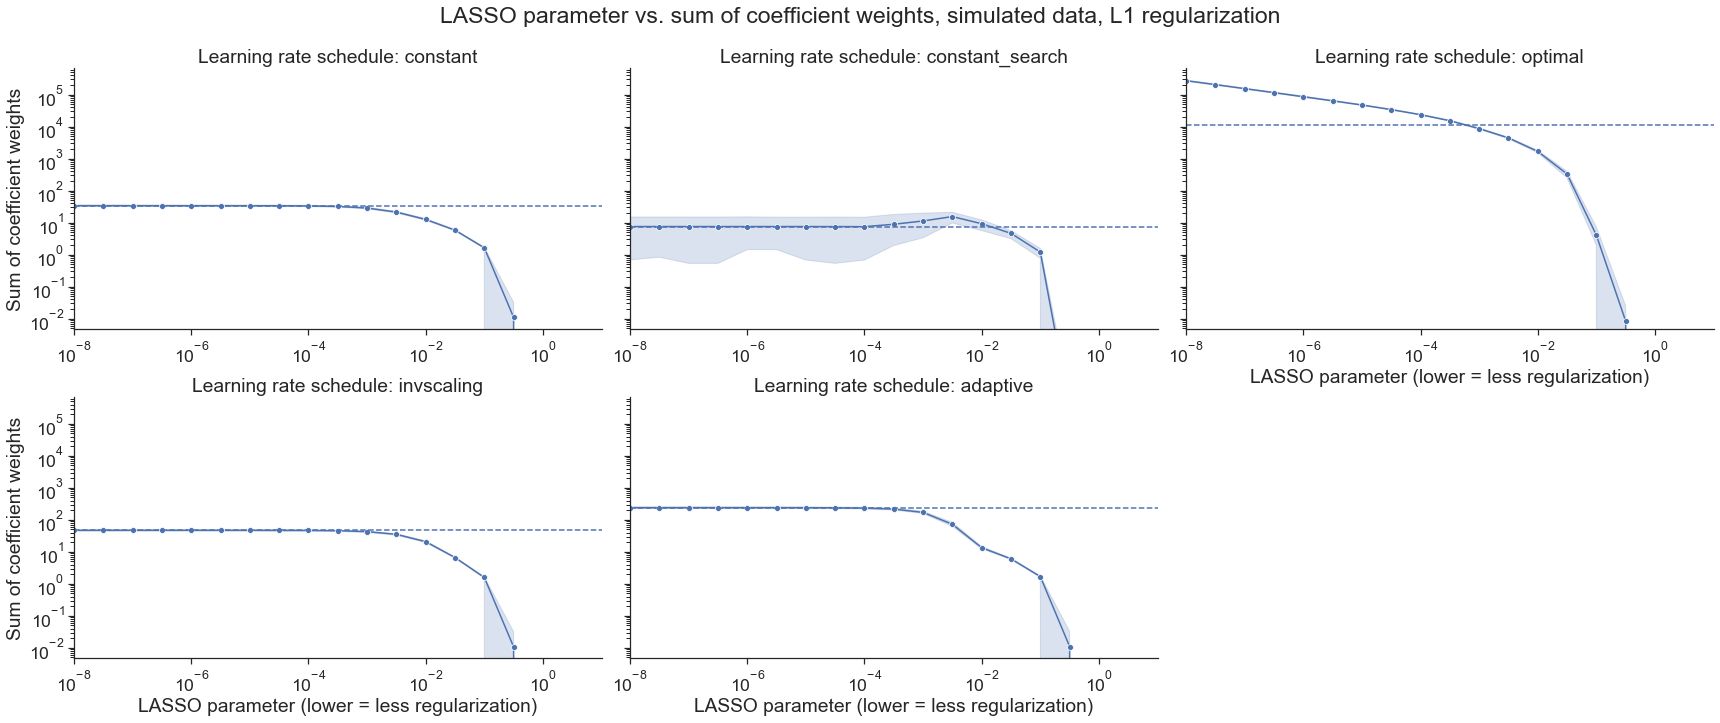

In [16]:
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=coefs_df,
        x='lasso_param', y='sum_coefs',
        marker='o', kind='line', col='lr_schedule',
        col_wrap=3, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log', yscale='log', xlim=(10e-9, 10))
    g.set_xlabels('LASSO parameter (lower = less regularization)')
    g.set_ylabels('Sum of coefficient weights')
    g.set_titles('Learning rate schedule: {col_name}')
    for i, ax in enumerate(g.axes):
        lr_schedule = list(coefs.keys())[i]
        ax.axhline(baseline_coefs_df[baseline_coefs_df.lr_schedule == lr_schedule].sum_coefs.mean(), linestyle='--')
     
    plt.suptitle(f'LASSO parameter vs. sum of coefficient weights, simulated data, L1 regularization', y=1.0)

plt.tight_layout()

In [14]:
# get coefficient vector magnitudes
losses_df = pd.DataFrame(
    losses,
    columns=['lr_schedule', 'seed', 'fold', 'lasso_param',
             'log_likelihood', 'weight_penalty']
)
losses_df['total_loss'] = losses_df.log_likelihood + losses_df.weight_penalty

losses_df = losses_df.melt(
    id_vars=['lr_schedule', 'seed', 'fold', 'lasso_param'],
    var_name='loss_component', value_name='loss_value'
)

print(losses_df.shape)
losses_df.head()

(1824, 6)


,lr_schedule,seed,fold,lasso_param,loss_component,loss_value
0,constant,42,0,1.000000e-08,log_likelihood,9.992007e-16
1,constant,42,0,3.162278e-08,log_likelihood,9.992007e-16
2,constant,42,0,1.000000e-07,log_likelihood,9.992007e-16
3,constant,42,0,3.162278e-07,log_likelihood,9.992007e-16
4,constant,42,0,1.000000e-06,log_likelihood,9.992007e-16


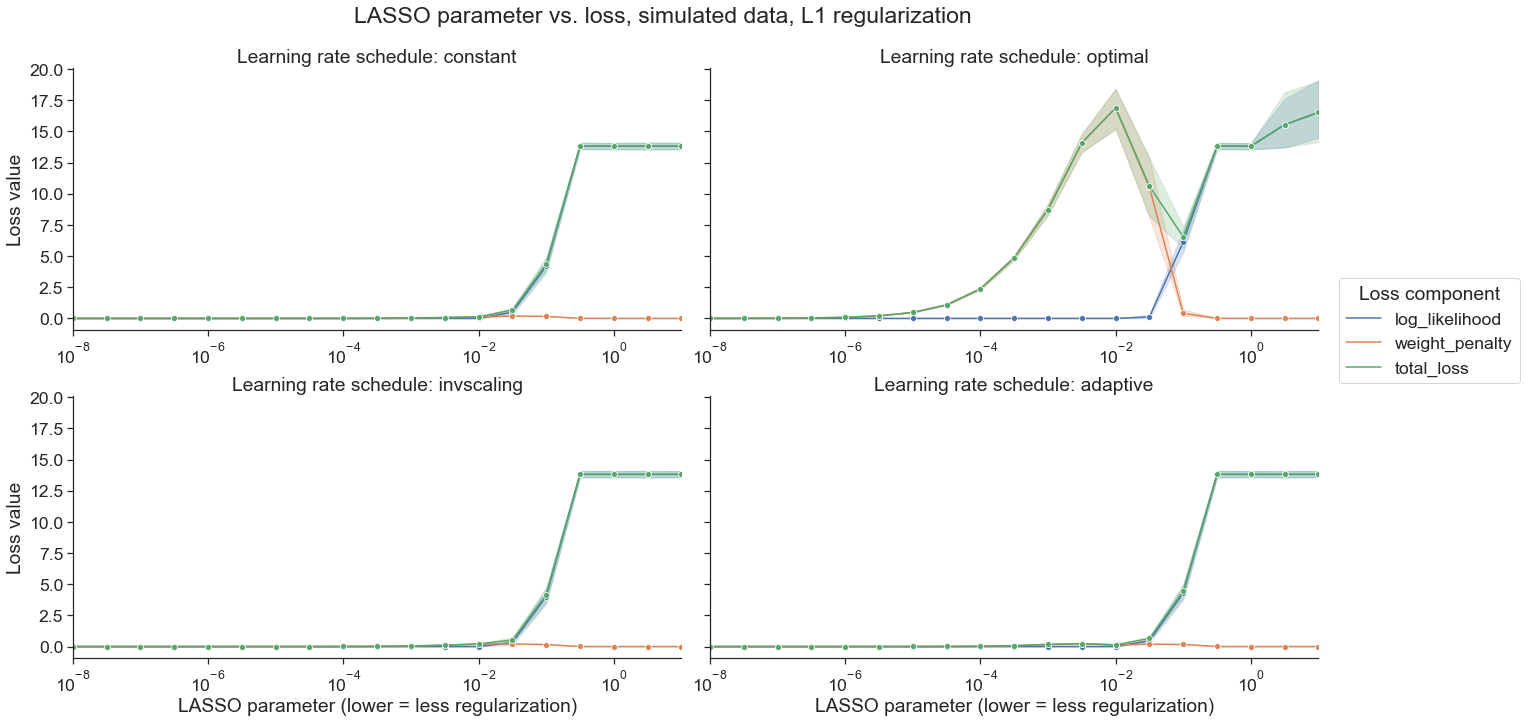

In [15]:
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=losses_df,
        x='lasso_param', y='loss_value', hue='loss_component',
        hue_order=['log_likelihood', 'weight_penalty', 'total_loss'],
        marker='o', kind='line', col='lr_schedule',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log',  xlim=(10e-9, 10))
    g.set_xlabels('LASSO parameter (lower = less regularization)')
    g.set_ylabels('Sum of coefficient weights')
    g.set_titles('Learning rate schedule: {col_name}')
    g.set_ylabels('Loss value')
    sns.move_legend(g, "center", bbox_to_anchor=[1.075, 0.55], frameon=True)
    g._legend.set_title('Loss component')
     
    plt.suptitle(f'LASSO parameter vs. loss, simulated data, L1 regularization', y=1.0)

plt.tight_layout()